# Youtube Comment Scraper

Youtube comment scraper function:

In [ ]:
from googleapiclient.discovery import build
import pandas as pd

#https://www.youtube.com/watch?v=hD1YtmKXNb4


def get_comment_replies(resource, comment_id, comments_dict):
    request = resource.comments().list(
        parentId=comment_id,
        part='id,snippet',
        maxResults=10
    )
    replies = 0
    response = request.execute()

    items = response["items"]

    for item in items:
        item_info = item["snippet"]
        # the top level comment can have sub reply comments
        comments_dict["name"].append(item_info["authorDisplayName"])
        comments_dict["comment"].append(item_info["textDisplay"])
        comments_dict["subcomment"].append(1)
        replies += 1

    return replies


def video_comments(video_id, num_of_comments, api_key):
    # build a resource for youtube
    resource = build('youtube', 'v3', developerKey=api_key)

    request = resource.commentThreads().list(
        part="snippet",
        videoId=video_id,
        maxResults=100,
        order="orderUnspecified")  # top comments.
    # execute the request
    response = request.execute()

    items = response["items"]

    comments_dict = {"name": [], "comment": [], "subcomment": []}

    count = 0

    while count < num_of_comments:
        p = False
        for item in items:
            item_info = item["snippet"]
            # the top level comment can have sub reply comments
            topLevelComment = item_info["topLevelComment"]
            comment_info = topLevelComment["snippet"]
            comments_dict["name"].append(comment_info["authorDisplayName"])
            comments_dict["comment"].append(comment_info["textDisplay"])
            comments_dict["subcomment"].append(0)
            rep_count = get_comment_replies(resource, item["id"], comments_dict)
            count += rep_count + 1
            if count == num_of_comments:
                p = True
                break
        if p:
            break
        if 'nextPageToken' in response:
            request = resource.commentThreads().list(
                part="snippet",
                videoId=video_id,
                maxResults=100,
                pageToken=response['nextPageToken'],
                order="orderUnspecified")  # top comments.
            # execute the request
            response = request.execute()
            items = response["items"]
        else:
            break

    df_comments = pd.DataFrame(comments_dict)
    return df_comments

# Filtering system for emails

## Data Preprocessing

Convert all letters to lower case. Remove punctuation, white space, numbers, hyperlink, stop words and etc. Use word stemming and word lemmatization.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
!pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 175 kB 24.7 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=692164a8b4c6ea496f0011b7ef73b15ac4719c605c9364c1ad3ea485368b0fe6
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [ ]:
from string import digits
from gensim.parsing.preprocessing import remove_stopwords
import string
import re
from cleantext import clean
from pprint import pprint

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(words):
   lemma_words = [lemmatizer.lemmatize(o) for o in words]
   return " ".join(lemma_words)

sheets = ['Youtube01-Psy', 'Youtube02-KatyPerry', 'Youtube03-LMFAO', 'Youtube04-Eminem', 'Youtube05-Shakira']
#sheets1 = ['comments_ltt', 'comments_mrbeast', 'comments_unspeakable']

all_comments = []
#all_comments1 = []
for sheet in sheets:
  wb = gc.open(sheet)

  rows = wb.sheet1.get_all_values()
  #rows

  
  for row in rows:
    if row[4] != 'CLASS':
    #if row[4] != 'spam':
      remove_digits = str.maketrans('', '', string.digits)
      remove_punct = str.maketrans('', '', string.punctuation)
      #res = row[3].lower().translate(remove_digits)
      res = remove_stopwords(row[3].lower().translate(remove_digits).translate(remove_punct)) # lowercase, remove punctuation, remove digits, remove stopwords
      clean_text = word_lemmatizer(res.split(" "))
      clean_text = word_lemmatizer(clean_text.split(" ")) # lemmatize
      clean_text = clean(clean_text, no_emoji=True) # remove emojis

      #print(clean_text) #
      # to spodnje je za kaggle dataset
      all_comments.append([clean_text, int(row[4])]) # save preprocessed text and class (0 - not spam or 1 - spam)
      
      #to spodnje je za nš dataset
      #all_comments1.append([clean_text, int(row[4])]) # save preprocessed text and class (0 - not spam or 1 - spam)


# pprint(all_comments)

In [ ]:


lemmatizer = WordNetLemmatizer()

def word_lemmatizer(words):
   lemma_words = [lemmatizer.lemmatize(o) for o in words]
   return " ".join(lemma_words)

#sheets = ['Youtube01-Psy', 'Youtube02-KatyPerry', 'Youtube03-LMFAO', 'Youtube04-Eminem', 'Youtube05-Shakira']
sheets1 = ['comments_ltt', 'comments_mrbeast', 'comments_unspeakable']

#all_comments = []
all_comments1 = []
for sheet in sheets1:
  wb = gc.open(sheet)

  rows = wb.sheet1.get_all_values()
  #rows

  
  for row in rows:
    # if row[4] != 'CLASS':
    if row[4] != 'spam':
      remove_digits = str.maketrans('', '', string.digits)
      remove_punct = str.maketrans('', '', string.punctuation)
      #res = row[3].lower().translate(remove_digits)
      res = remove_stopwords(row[2].lower().translate(remove_digits).translate(remove_punct)) # lowercase, remove punctuation, remove digits, remove stopwords
      clean_text = word_lemmatizer(res.split(" "))
      clean_text = word_lemmatizer(clean_text.split(" ")) # lemmatize
      clean_text = clean(clean_text, no_emoji=True) # remove emojis

      #print(clean_text) #
      # to spodnje je za kaggle dataset
      # all_comments.append([clean_text, int(row[4])]) # save preprocessed text and class (0 - not spam or 1 - spam)
      
      #to spodnje je za nš dataset
      all_comments1.append([clean_text, int(row[4])]) # save preprocessed text and class (0 - not spam or 1 - spam)


# pprint(all_comments1)

In [ ]:

a = [c[1] for c in all_comments1]
print(sum(a))
print(len(a)-sum(a))
print(len(a))


179
1409
1588


In [ ]:
x_train = [x[0] for x in all_comments]
y_train = [x[1] for x in all_comments]
x_test = [x[0] for x in all_comments1]
y_test = [x[1] for x in all_comments1]

print("Majority class classification accuracy:", 1 - sum(y_test)/len(x_test))

Majority class classification accuracy: 0.8872795969773299


## CNN

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

ham_sample = train_test_split([c for c, spam in all_comments if not spam])
ham_train, ham_test = ham_sample
spam_sample = train_test_split([c for c, spam in all_comments if spam])
spam_train, spam_test = spam_sample
print("ham:", len(ham_train), len(ham_test))
print("spam:", len(spam_train), len(spam_test))

ham_train_label = [0] * len(ham_train)
spam_train_label = [1] * len(spam_train)
x_train = np.concatenate((ham_train, spam_train))
y_train = np.concatenate((ham_train_label, spam_train_label))
print("size of train set:", x_train.shape)

ham_test_label = [0] * len(ham_test)
spam_test_label = [1] * len(spam_test)
x_test = np.concatenate((ham_test, spam_test))
y_test = np.concatenate((ham_test_label, spam_test_label))
print("size of test set:", x_test.shape)

train_shuffle_index = np.random.permutation(np.arange(0, x_train.shape[0]))
test_shuffle_index = np.random.permutation(np.arange(0, x_test.shape[0]))

"""
x_train = all_comments1[:1088][0]
y_train = all_comments1[:1088][1]
x_test = all_comments1[1088:][0]
y_test = all_comments1[1088:][1]
"""

x_train = x_train[train_shuffle_index]
y_train = y_train[train_shuffle_index]
x_test = x_test[test_shuffle_index]
y_test = y_test[test_shuffle_index]
print(len(spam_test)/(len(ham_test)+len(spam_test)))

ham: 713 238
spam: 753 252
size of train set: (1466,)
size of test set: (490,)
0.5142857142857142


In [ ]:
print(all_comments1)

[['bigger picture better theyre blocking ambient light painting wall black buying screen need worry losing light projector', 0], ['linus drop tip', 0], ['there grown man like linus jumping box tech hand make smile', 0], ['best crack ive seen', 0], ['m y oof habe money buy buy big oled ffs', 0], ['laugh', 0], ['hrefhttpswwwyoutubecomwatchvurvspcjamptmsa press linus exit', 0], ['isnt cheap', 0], ['point jake room linus house', 0], ['fart', 0], ['friend told video hunt fucking obnoxious click bait title unsubbed', 0], ['lumen lumen thats way weak', 0], ['projector cardboard box', 0], ['im thinking jackery farting', 0], ['hahahaha quotbest bang buckquot yea sure nice hrefhttpwwwyoutubecomresultssearchqueryadada best bang buck true p projector got amazon paired quot screen l', 0], ['quotdude therere video makequot time linus make video project house get write cost cost project k projector business expense', 0], ['epson rly happy video', 0], ['ahhhdreams goal', 0], ['box mounted projector ga

In [ ]:
all_comments1 = np.array(all_comments1)

review = all_comments1[:,0]
label = all_comments1[:,1].astype(int)
review_train, review_test, label_train, label_test = train_test_split( review, label, test_size=0.25, random_state=1000) 

print(label)



[0 0 0 ... 0 0 0]


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(review_train)

Xcnn_train = tokenizer.texts_to_sequences(review_train)
Xcnn_test = tokenizer.texts_to_sequences(review_test)

vocab_size = len(tokenizer.word_index) + 1  
print(review_train[1])
print(Xcnn_train[1]) 


maxlen = 50
Xcnn_train = pad_sequences(Xcnn_train, padding='post', maxlen=maxlen)
Xcnn_test = pad_sequences(Xcnn_test, padding='post', maxlen=maxlen)
print(Xcnn_train[0, :]) 

deeznuts
[773]
[253 128 772 328   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [ ]:
from keras.models import Sequential
from keras import layers 



embedding_dim = 200
textcnnmodel = Sequential()
textcnnmodel.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
textcnnmodel.add(layers.Conv1D(128, 5, activation='relu'))
textcnnmodel.add(layers.GlobalMaxPooling1D())
textcnnmodel.add(layers.Dense(10, activation='relu'))
textcnnmodel.add(layers.Dense(1, activation='sigmoid'))
textcnnmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
textcnnmodel.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 200)           460800    
                                                                 
 conv1d (Conv1D)             (None, 46, 128)           128128    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 590,229
Trainable params: 590,229
Non-trainable params: 0
__________________________________________________

In [ ]:
print(Xcnn_train)
print(label_train)
print(Xcnn_test)
print(label_test)

[[ 253  128  772 ...    0    0    0]
 [ 773    0    0 ...    0    0    0]
 [ 473  105  254 ...    0    0    0]
 ...
 [2299 2300  165 ...    0    0    0]
 [  35   30    8 ...    0    0    0]
 [ 162  486 2301 ...    0    0    0]]
[0 0 0 ... 0 1 0]
[[ 306   33  623 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [ 261  231    0 ...    0    0    0]
 ...
 [ 197  541  197 ...    0    0    0]
 [  28 2204    0 ...    0    0    0]
 [   2  150  951 ...    0    0    0]]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 

In [ ]:
textcnnmodel.fit(Xcnn_train, label_train, validation_data=(Xcnn_test, label_test), 
                epochs=16,
                verbose=False, batch_size=32
                 )
loss, accuracy = textcnnmodel.evaluate(Xcnn_train, label_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = textcnnmodel.evaluate(Xcnn_test, label_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.9975


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate(model, review_test, label_test):
  # loss, accuracy = model.evaluate(review_test, label_test, verbose=False)
  # accuracy = model.score(review_test, label_test)
  label_predict = model.predict(Xcnn_test, verbose=1)
  label_predict = [int(x) for x in np.around(label_predict, decimals=1)]
  accuracy = accuracy_score(label_test, label_predict)
  f1 = f1_score(label_test, label_predict)
  precision = precision_score(label_test, label_predict)
  recall = recall_score(label_test, label_predict)
  return accuracy, f1, precision, recall

accuracy, f1_score, precision, recall = evaluate(textcnnmodel, review_test, label_test)
print(f'accuracy: {accuracy:.2f}\nf1: {f1_score:.2f}\nprecision: {precision:.2f}\nrecall: {recall:.2f}')

13/13 [==============================] - 0s 10ms/step
accuracy: 0.99
f1: 0.98
precision: 0.98
recall: 0.98


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
textcnnmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# fit the model
history = textcnnmodel.fit(Xcnn_train, label_train, validation_split=0.3, epochs=10, verbose=0)

# evaluate the model
loss, accuracy, f1_score, precision, recall = textcnnmodel.evaluate(Xcnn_test, label_test, verbose=0)
print(f'accuracy: {accuracy:.4f}\nf1: {f1_score:.2f}\nprecision: {precision:.2f}\nrecall: {recall:.2f}')

accuracy: 0.9975
f1: 0.91
precision: 0.90
recall: 0.92


## Naive Bayes

### Feature Extraction

In [ ]:
print(all_comments[210])

['friend read book repass httpwwwsharedcomwebpreviewpdfcjfoftxeba', 1]


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# list of comments
comments = [text for text, is_spam in all_comments]

# create the transform
vectorizer = CountVectorizer(lowercase=False)

# tokenize and build vocab
vectorizer.fit(comments)
print(vectorizer.vocabulary_)

# encode document
count_vector = vectorizer.transform(comments)
print(count_vector.shape)
print(type(count_vector))
print(count_vector.toarray())

{'huh': 1585, 'check': 462, 'youtube': 3624, 'channel': 446, 'kobyoshi': 1814, 'hey': 1343, 'guy': 1266, 'new': 2216, 'vid': 3382, 'monkey': 2134, 'im': 1626, 'white': 3508, 'shirtplease': 2835, 'leave': 1860, 'like': 1882, 'comment': 544, 'subscribe': 3057, 'test': 3167, 'murdevcom': 2172, 'shaking': 2816, 'sexy': 2810, 'enjoy': 891, 'watchvvtarggvgtwq': 3469, 'website': 3484, 'site': 2884, 'kid': 1791, 'stuff': 3045, 'kidsmediausa': 1793, 'com': 534, 'turned': 3298, 'mute': 2183, 'soon': 2950, 'came': 396, 'wanted': 3442, 'views': 3398, 'funny': 1138, 'videos': 3387, 'shouldd': 2850, 'tell': 3158, 'next': 2219, 'me': 2035, 'started': 3010, 'reading': 2608, 'stop': 3028, 'day': 688, 'youre': 3621, 'entire': 904, 'family': 986, 'die': 741, 'want': 3441, 'stay': 3015, 'alive': 92, 'right': 2692, 'now': 2258, 'httpstwittercomgbphotographygb': 1476, 'httpspremiumeasypromosappcomvoteme': 1467, 'hello': 1329, 'gaming': 1152, 'art': 164, 'video': 3383, 'scientific': 2765, 'experiment': 951, 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create the transform
vectorizer = TfidfVectorizer()

# tokenize and build vocab
vectorizer.fit(comments)
print(vectorizer.vocabulary_)
print(vectorizer.idf_)

# encode document
freq_vector = vectorizer.transform(comments)
print(freq_vector.shape)
print(freq_vector.toarray())

{'huh': 1585, 'check': 462, 'youtube': 3624, 'channel': 446, 'kobyoshi': 1814, 'hey': 1343, 'guy': 1266, 'new': 2216, 'vid': 3382, 'monkey': 2134, 'im': 1626, 'white': 3508, 'shirtplease': 2835, 'leave': 1860, 'like': 1882, 'comment': 544, 'subscribe': 3057, 'test': 3167, 'murdevcom': 2172, 'shaking': 2816, 'sexy': 2810, 'enjoy': 891, 'watchvvtarggvgtwq': 3469, 'website': 3484, 'site': 2884, 'kid': 1791, 'stuff': 3045, 'kidsmediausa': 1793, 'com': 534, 'turned': 3298, 'mute': 2183, 'soon': 2950, 'came': 396, 'wanted': 3442, 'views': 3398, 'funny': 1138, 'videos': 3387, 'shouldd': 2850, 'tell': 3158, 'next': 2219, 'me': 2035, 'started': 3010, 'reading': 2608, 'stop': 3028, 'day': 688, 'youre': 3621, 'entire': 904, 'family': 986, 'die': 741, 'want': 3441, 'stay': 3015, 'alive': 92, 'right': 2692, 'now': 2258, 'httpstwittercomgbphotographygb': 1476, 'httpspremiumeasypromosappcomvoteme': 1467, 'hello': 1329, 'gaming': 1152, 'art': 164, 'video': 3383, 'scientific': 2765, 'experiment': 951, 

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

# create the transform
vectorizer = HashingVectorizer(n_features=20)

# encode document
hash_vector = vectorizer.transform(comments)
print(hash_vector.shape)
print(hash_vector.toarray())

(1956, 20)
[[0.         0.         0.         ... 0.         0.         0.75592895]
 [0.6882472  0.         0.         ... 0.         0.22941573 0.22941573]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


### Scoring & Metrics

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

ham_sample = train_test_split([c for c, spam in all_comments if spam == '0'])
ham_train, ham_test = ham_sample
spam_sample = train_test_split([c for c, spam in all_comments if spam == '1'])
spam_train, spam_test = spam_sample
print("ham:", len(ham_train)+ len(ham_test))
print("spam:", len(spam_train)+ len(spam_test))

ValueError: ignored

In [ ]:
ham_train_label = [0] * len(ham_train)
spam_train_label = [1] * len(spam_train)
x_train = np.concatenate((ham_train, spam_train))
y_train = np.concatenate((ham_train_label, spam_train_label))
print("size of train set:", x_train.shape)

ham_test_label = [0] * len(ham_test)
spam_test_label = [1] * len(spam_test)
x_test = np.concatenate((ham_test, spam_test))
y_test = np.concatenate((ham_test_label, spam_test_label))
print("size of test set:", x_test.shape)

train_shuffle_index = np.random.permutation(np.arange(0, x_train.shape[0]))
test_shuffle_index = np.random.permutation(np.arange(0, x_test.shape[0]))

x_train = x_train[train_shuffle_index]
y_train = y_train[train_shuffle_index]
x_test = x_test[test_shuffle_index]
y_test = y_test[test_shuffle_index]

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

vectorizers = [CountVectorizer(lowercase=False), TfidfVectorizer(), HashingVectorizer(n_features=20)]
for vectorizer in vectorizers:
  vectorizer.fit(x_train)

  x_train_features = vectorizer.transform(x_train)
  x_test_features = vectorizer.transform(x_test)

  clf = GaussianNB()
  clf.fit(x_train_features.toarray(),y_train)

  # Output of the score is the accuracy of the prediction
  train_score = clf.score(x_train_features.toarray(),y_train)
  test_score = clf.score(x_test_features.toarray(),y_test)
  print(train_score, test_score, vectorizer)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

y_predict = clf.predict(x_test_features.toarray())
# print(confusion_matrix(y_test,y_predict))

tn, fp, fn, tp = confusion_matrix(y_test,y_predict).ravel()
print("F1: {:.2f}%".format(100 * f1_score(y_test, y_predict)))
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predict)))

## SVM

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

cv = CountVectorizer() 
X_train = cv.fit_transform(x_train)
X_test = cv.transform(x_test)

svm = SVC(kernel = 'rbf', random_state = 0)
svm.fit(X_train, y_train)

# print(svm.score(X_test,y_test))

y_predict = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)

print(f'accuracy: {accuracy:.2f}\nf1: {f1:.2f}\nprecision: {precision:.2f}\nrecall: {recall:.2f}')

## Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=2)
rf.fit(X_train, y_train)

y_predict = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)

print(f'accuracy: {accuracy:.2f}\nf1: {f1:.2f}\nprecision: {precision:.2f}\nrecall: {recall:.2f}')

## Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=131, verbose=2, random_state=42)
lr.fit(X_train, y_train)

y_predict = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)

print(f'accuracy: {accuracy:.2f}\nf1: {f1:.2f}\nprecision: {precision:.2f}\nrecall: {recall:.2f}\n')

## K-nearest neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_predict = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)

print(f'accuracy: {accuracy:.2f}\nf1: {f1:.2f}\nprecision: {precision:.2f}\nrecall: {recall:.2f}\n')

# Comparing different models



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
!pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 5.0 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=88c5f90fa17ef5377a1b1b33477f141d48276429f858a74c92df07eba43c657e
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [ ]:
!cp drive/MyDrive/data.py 'data.py'
!cp drive/MyDrive/models.py 'models.py'

In [ ]:
import data, models
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import importlib

importlib.reload(data)
importlib.reload(models)

# data
kaggle_x_train, kaggle_y_train, kaggle_x_test, kaggle_y_test = data.youtube_comments()
# scraper_x_train, scraper_y_train, scraper_x_test, scraper_y_test = data.my_youtube_comments()

# take kaggle dataset as train data and scraper dataset as test data
# kaggle_x_train, kaggle_y_train = np.concatenate((kaggle_x_train, kaggle_x_test)), np.concatenate((kaggle_y_train, kaggle_y_test))
# kaggle_x_test, kaggle_y_test = np.concatenate((scraper_x_train, scraper_x_test)), np.concatenate((scraper_y_train, scraper_y_test))

# models
models_scores = []
model = GaussianNB()
models_scores.append(models.evaluate_model(kaggle_x_train, kaggle_y_train, kaggle_x_test, kaggle_y_test, model))
model = KNeighborsClassifier(n_neighbors=5)
models_scores.append(models.evaluate_model(kaggle_x_train, kaggle_y_train, kaggle_x_test, kaggle_y_test, model))
model = RandomForestClassifier(max_depth=2)
models_scores.append(models.evaluate_model(kaggle_x_train, kaggle_y_train, kaggle_x_test, kaggle_y_test, model))
model = SVC(kernel = 'rbf', random_state = 0)
models_scores.append(models.evaluate_model(kaggle_x_train, kaggle_y_train, kaggle_x_test, kaggle_y_test, model))
models_scores.append(models.cnn(kaggle_x_train, kaggle_y_train, kaggle_x_test, kaggle_y_test))
model = LogisticRegression(max_iter=131, verbose=2, random_state=42)
models_scores.append(models.evaluate_model(kaggle_x_train, kaggle_y_train, kaggle_x_test, kaggle_y_test, model))

# models_scores[0] = models.nb(kaggle_x_train, kaggle_y_train, kaggle_x_test, kaggle_y_test, 0)
# models_scores[1] = models.nb(kaggle_x_train, kaggle_y_train, kaggle_x_test, kaggle_y_test, 1)
# models_scores[2] = models.nb(kaggle_x_train, kaggle_y_train, kaggle_x_test, kaggle_y_test, 2)

# comparison
# specificity, sensitivity
models = ['nb', 'knn', 'rf', 'svm', 'cnn', 'lr']
scores = ['accuracy', 'f1', 'precision', 'recall']
pd.DataFrame(models_scores, models, scores)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


19/19 [==============================] - 0s 9ms/step


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

,accuracy,f1,precision,recall
nb,1.00,1.0,1.0,1.0
knn,1.00,1.0,1.0,1.0
rf,0.95,0.0,0.0,0.0
svm,1.00,1.0,1.0,1.0
cnn,1.00,1.0,1.0,1.0
lr,1.00,1.0,1.0,1.0


In [ ]:
import data, models
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import importlib

importlib.reload(data)
importlib.reload(models)

# data
kaggle_x_train, kaggle_y_train, kaggle_x_test, kaggle_y_test = data.youtube_comments()

models_scores = []
models_scores.append(models.nb(kaggle_x_train, kaggle_y_train, kaggle_x_test, kaggle_y_test, 0))
models_scores.append(models.nb(kaggle_x_train, kaggle_y_train, kaggle_x_test, kaggle_y_test, 1))
models_scores.append(models.nb(kaggle_x_train, kaggle_y_train, kaggle_x_test, kaggle_y_test, 2))

# comparison
models = ['nb count', 'nb tfidf', 'nb hash']
scores = ['accuracy', 'f1', 'precision', 'recall']
pd.DataFrame(models_scores, models, scores)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
ham: 713 238
spam: 753 252


,accuracy,f1,precision,recall
nb count,0.746939,0.719457,0.836842,0.630952
nb tfidf,0.736735,0.715232,0.805970,0.642857
nb hash,0.671429,0.686160,0.674330,0.698413


In [ ]:
len(kaggle_x_train), len(kaggle_x_test)

(1190, 398)

In [ ]:
df = pd.DataFrame(models_scores, models, scores)
df.sort_values(by=['accuracy'])

,accuracy,f1,precision,recall
nb,0.248744,0.227390,0.128655,0.977778
rf,0.886935,0.000000,0.000000,0.000000
lr,0.964824,0.820513,0.969697,0.711111
knn,0.987437,0.942529,0.976190,0.911111
svm,0.987437,0.943820,0.954545,0.933333
cnn,0.994975,0.977778,0.977778,0.977778


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


FP: ["thanks commenting brcongratulations y' randomly selected dm meai claim prize y'", "y'congratulations yzsyou selected shortlisted winnersbrbrtelegram claim giveaway prizeyzysyz", 'iicongratulations yz shortlisted winner claim pcy"y"', 'iicongratulations yz shortlisted winner claim pcy"y"', 'congratulation aiaiaibrclaim prizey"iy"ibrtelegram y"y"', "thi~ksfii' iitchi~gbrwhitsipi12148149371y'lets talk bigger introduce", "y' congratulation won prize right away yzy'", "thi~ksfii' iitchi~gbrwhitsipi12148149371y'lets talk bigger introduce", "lol y' watsap y' br", "thi~ksfii' iitchi~gbrwhitsipi12148149371y'lets talk bigger introduce", "watsap y' br", "thanks commenting brcongratulations y' randomly selected dm meai claim prize y'", 'iicongratulations yz shortlisted winner claim pcy"y"', "y'congratulations yzsyou selected shortlisted winnersbrbrtelegram claim giveaway prizeyzys", "y'y'y'brthanks watching leaving commentbrtelegram claim prize yzyz", "y'congratulations yzsyou selected short

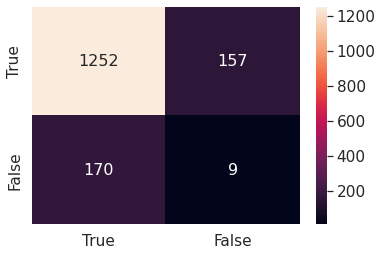

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

cv = CountVectorizer() 
X_train = cv.fit_transform(kaggle_x_train)
X_test = cv.transform(kaggle_x_test)

lr = LogisticRegression(max_iter=131, verbose=2, random_state=42)
lr.fit(X_train.toarray(), kaggle_y_train)
y_predict = lr.predict(X_test.toarray())

FP = [kaggle_x_test[i] for i, x in enumerate(kaggle_y_test) if x == 1 and y_predict[i] == 0]
print("FP:", FP)

conf_mat = confusion_matrix(kaggle_y_test, y_predict)
df_cm = pd.DataFrame(conf_mat, index = ['True','False'], columns = ['True','False'])
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g', annot_kws={"size": 16})
plt.show()

# Data info

In [ ]:
import pandas as pd
data = [['running','-ing','run'],['runs','-s','run'],['consolidate','-ate','consolid'],['consolidated','-ated','consolid']]
pd.DataFrame(data, columns=['Form','Suffix','Stem'])

data = [['studies','Present tense of the word study','study'],['ran', 'Past tense of the word run', 'run']]
pd.DataFrame(data, columns=['Form','Morphological Information','Lemma'])

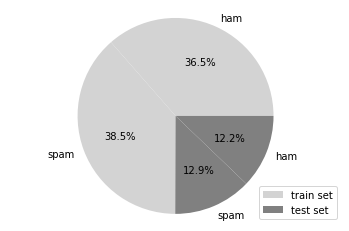

In [ ]:
import matplotlib.pyplot as plt

labels = 'ham', 'spam', 'spam', 'ham'
sizes = [713, 753, 252, 238]
# sizes = [1056, 353, 45, 134]
colors = ['lightgray', 'lightgray', 'gray', 'gray']

patches, _, _ = plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.legend([patches[0], patches[2]], ['train set', 'test set'], loc="best")

plt.axis('equal')
plt.show()

In [ ]:
1-252/753, 1-238/713

(0.6653386454183268, 0.6661991584852736)